In [1]:
#Importing Libraries

import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
import matplotlib.pyplot as plt
import os
import itertools

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Check if GPU is available

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [4]:
#Downloading the data and resizing it such that it can be directly feeded to the model

transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class PatchSSLModel(torch.nn.Module):
    def __init__(self, num_classes):
        super(PatchSSLModel, self).__init__()
        self.resnet = resnet18(pretrained=False)
        self.resnet.fc = torch.nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [6]:
class RelativePatchDataset(Dataset):

    rel_pos = {
        (-1, -1): 0,
        (-1, 0): 1,
        (-1, 1): 2,
        (0, -1): 3,
        (0, 0): 4,
        (0, 1): 5,
        (1, -1): 6,
        (1, 0): 7,
        (1, 1): 8}

    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image, _ = self.base_dataset[idx]

        height, width = image.shape[1] // 3, image.shape[2] // 3

        start_height = height
        start_width = width
        end_height = height * 2
        end_width = width * 2

        center_patch = image[:, start_height:end_height, start_width:end_width]

        if center_patch.shape[1] != height or center_patch.shape[2] != width:
            center_patch = self.pad_patch(center_patch)

        relative_pos = list(self.rel_pos.keys())
        relative_pos.remove((0, 0))
        index = np.random.randint(0, len(relative_pos))
        position = relative_pos[index]

        start_height += position[0] * height
        end_height += position[0] * height
        start_width += position[1] * width
        end_width += position[1] * width

        label = self.rel_pos[position]
        neighbor_patch = image[:, start_height:end_height, start_width:end_width]

        if neighbor_patch.shape[1] != height or neighbor_patch.shape[2] != width:
            padding_height = 2**5 - neighbor_patch.shape[1]
            padding_width = 2**5 - neighbor_patch.shape[2]
            neighbor_patch = F.pad(neighbor_patch, (padding_width//2, padding_width-padding_width//2, padding_height//2, padding_height-padding_height//2), 'reflect')
        combined_image = torch.cat((center_patch, neighbor_patch), dim=2)

        return combined_image,label

In [7]:
def visualize_relative_patch(images,labels, num_images=5):
    fig, axs = plt.subplots(num_images, 2, figsize=(4, 7))
    for i in range(num_images):
        for j in range(2):
            patch = images[i, :, :, j*32:(j+1)*32].cpu().numpy()
            if patch.size == 0:
                continue
            axs[i, j].imshow(np.transpose((patch * 0.5) + 0.5, (1, 2, 0)))
            if j == 0:
                axs[i, j].set_title(f"Center Patch")
            else:
                axs[i, j].set_title(f"Relative Patch: {labels[i].item()}")
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

In [8]:
relative_patch_model = PatchSSLModel(num_classes=9).to(device)
optimizer_relative = torch.optim.Adam(relative_patch_model.parameters(), lr=0.0005)

In [9]:
from torch.utils.data import random_split
val_size = 5000  # You can adjust this size as needed
# Calculate the size of the training set (excluding the validation set)
train_size = len(train_dataset) - val_size

# Split the training dataset into training and validation sets
train_set, val_set = random_split(train_dataset, [train_size, val_size])

relative_patch_dataset = RelativePatchDataset(train_set)
relative_patch_loader = DataLoader(relative_patch_dataset, batch_size=32, shuffle=True)

relative_patch_dataset_dev = RelativePatchDataset(val_set)
relative_patch_loader_dev = DataLoader(relative_patch_dataset, batch_size=32, shuffle=False)

relative_patch_test_dataset = RelativePatchDataset(test_dataset)
relative_patch_test_loader = DataLoader(relative_patch_test_dataset, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

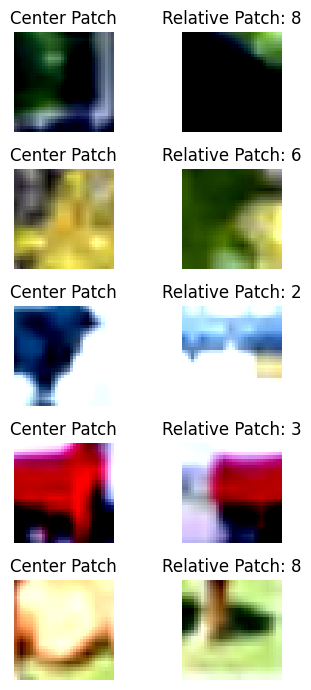

In [10]:
images,sample_labels = next(iter(relative_patch_loader))
visualize_relative_patch(images, sample_labels)

In [11]:
criterion = torch.nn.CrossEntropyLoss()

In [12]:
#Training the model

for epoch in range(1, 11):
    relative_patch_model.train()
    correct = 0
    total = 0
    print ("Epoch %d" % epoch)
    for images,labels in relative_patch_loader:
        images, labels = images.to(device),labels.to(device)
        optimizer_relative.zero_grad()
        outputs = relative_patch_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_relative.step()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Training Accuracy: %d %%' % (100 * correct / total))

    correct = 0
    total = 0
    relative_patch_model.eval()
    for images, labels in relative_patch_loader_dev:
        images, labels = images.to(device),labels.to(device)
        outputs = relative_patch_model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Validation Accuracy: %d %%' % (100 * correct / total))

    print()

Epoch 1
Training Accuracy: 49 %
Validation Accuracy: 73 %

Epoch 2
Training Accuracy: 89 %
Validation Accuracy: 93 %

Epoch 3
Training Accuracy: 95 %
Validation Accuracy: 96 %

Epoch 4
Training Accuracy: 95 %
Validation Accuracy: 97 %

Epoch 5
Training Accuracy: 96 %
Validation Accuracy: 97 %

Epoch 6
Training Accuracy: 97 %
Validation Accuracy: 98 %

Epoch 7
Training Accuracy: 97 %
Validation Accuracy: 98 %

Epoch 8
Training Accuracy: 97 %
Validation Accuracy: 97 %

Epoch 9
Training Accuracy: 98 %
Validation Accuracy: 98 %

Epoch 10
Training Accuracy: 98 %
Validation Accuracy: 97 %



In [13]:
correct = 0
total = 0
relative_patch_model.eval()
for images, labels in relative_patch_test_loader:
    images,  labels = images.to(device), labels.to(device)
    outputs = relative_patch_model(images)
    loss = criterion(outputs, labels)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print('Test Accuracy: %d %%' % (100 * correct / total))


Test Accuracy: 97 %


In [14]:
torch.save(relative_patch_model.state_dict(),'patch_prediction_SSL.pt')

In [15]:
downstream_model = PatchSSLModel(num_classes=9).to(device)

# downstream_model.resnet = relative_patch_model.resnet

checkpoint = torch.load("patch_prediction_SSL.pt")

new_checkpoint = {}

# Iterate through the keys in the loaded checkpoint
for key, value in checkpoint.items():
    # Modify the key to match the existing model's module name
    new_key = key.replace('module.', '')  # Remove 'module.' prefix if it exists
    new_checkpoint[new_key] = value

downstream_model.load_state_dict(new_checkpoint)
downstream_model.resnet.fc = torch.nn.Linear(512,10)

In [16]:
downstream_model.to(device)
optimizer_downstream = torch.optim.Adam(downstream_model.parameters(), lr=0.001)

In [17]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

val_size = 5000  # You can adjust this size as needed
# Calculate the size of the training set (excluding the validation set)
train_size = len(train_dataset) - val_size

# Split the training dataset into training and validation sets
train_set, val_set = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
for epoch in range(1,26):  # Train for 10 epochs or as needed
    correct = 0
    total = 0
    print ("Epoch %d" % epoch)
    downstream_model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer_downstream.zero_grad()
        outputs = downstream_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_downstream.step()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Training Accuracy Downstream: %d %%' % (100 * correct / total))

    correct = 0
    total = 0
    downstream_model.eval()
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = downstream_model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Validation Accuracy Downstream: %d %%' % (100 * correct / total))
    print()

Epoch 1
Training Accuracy Downstream: 45 %
Validation Accuracy Downstream: 58 %

Epoch 2
Training Accuracy Downstream: 61 %
Validation Accuracy Downstream: 63 %

Epoch 3
Training Accuracy Downstream: 67 %
Validation Accuracy Downstream: 67 %

Epoch 4
Training Accuracy Downstream: 72 %
Validation Accuracy Downstream: 70 %

Epoch 5
Training Accuracy Downstream: 77 %
Validation Accuracy Downstream: 71 %

Epoch 6
Training Accuracy Downstream: 80 %
Validation Accuracy Downstream: 72 %

Epoch 7
Training Accuracy Downstream: 83 %
Validation Accuracy Downstream: 72 %

Epoch 8
Training Accuracy Downstream: 86 %
Validation Accuracy Downstream: 74 %

Epoch 9
Training Accuracy Downstream: 89 %
Validation Accuracy Downstream: 74 %

Epoch 10
Training Accuracy Downstream: 91 %
Validation Accuracy Downstream: 74 %

Epoch 11
Training Accuracy Downstream: 92 %
Validation Accuracy Downstream: 74 %

Epoch 12
Training Accuracy Downstream: 93 %
Validation Accuracy Downstream: 72 %

Epoch 13
Training Accurac

In [19]:
correct = 0
total = 0
for images, labels in test_loader:
  images, labels = images.to(device), labels.to(device)
  outputs = downstream_model(images)
  _, predicted = torch.max(outputs, 1)
  total += labels.size(0)
  correct += (predicted == labels).sum().item()
print('Test Accuracy Downstream: %d %%' % (100 * correct / total))

Test Accuracy Downstream: 74 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

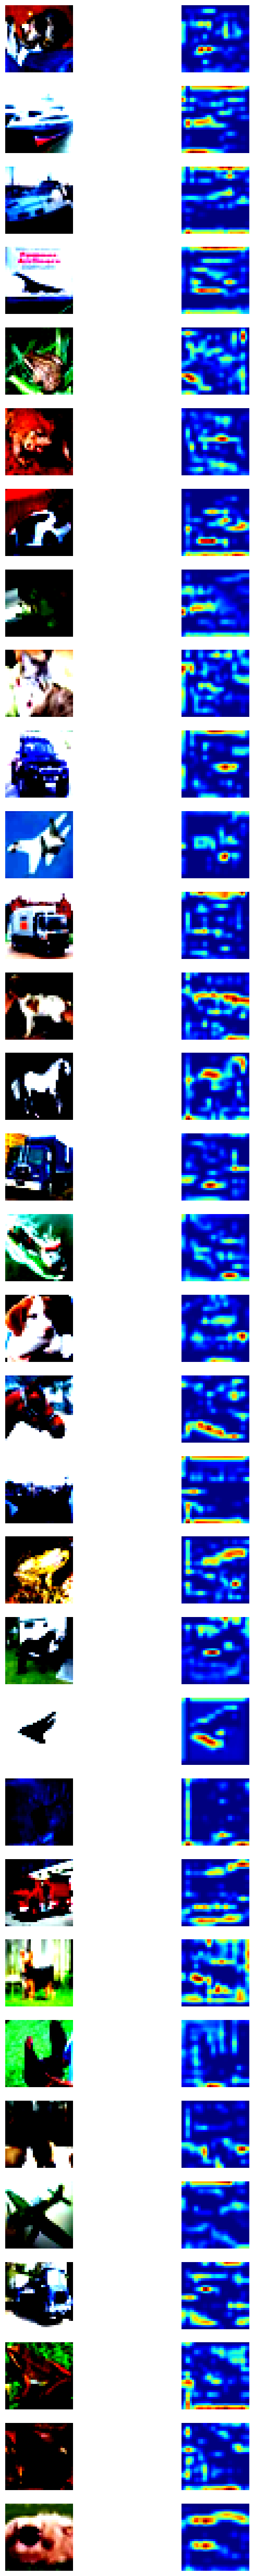

In [20]:
relative_patch_model.eval()
# GradCAM class
model_to_train = relative_patch_model.cpu()
device = 'cpu'
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        # Hook the gradients
        self.h = []
        self.h.append(self.target_layer.register_backward_hook(self.save_gradients))

    def save_gradients(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def __call__(self, inputs, class_idx=None):

        outputs = self.model(inputs)
        # print(outputs)
        if class_idx is None:
            class_idx = torch.argmax(outputs).item()


        self.model.zero_grad()

        # Backward pass with specified class
        one_hot = torch.zeros((1, outputs.size()[-1]), dtype=torch.float32).to(device)
        one_hot[0][class_idx] = 1
        outputs.backward(gradient=one_hot, retain_graph=True)

        # Get activations
        # print(inputs.shape)
        activations = self.target_layer.forward(inputs)

        # Average the gradients spatially
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)

        # Compute GradCAM map
        grad_cam_map = torch.sum(weights * activations, dim=1, keepdim=True)
        grad_cam_map = F.relu(grad_cam_map)
        grad_cam_map = F.interpolate(grad_cam_map, size=(inputs.size(2), inputs.size(3)), mode='bilinear', align_corners=False)

        # Remove the anchor to pull information from layers
        for h in self.h:
            h.remove()

        return grad_cam_map

# Visualization function
def visualize_gradcam(img, mask):
    heatmap = (mask - mask.min()) / (mask.max() - mask.min())
    heatmap = np.uint8(255 * heatmap)
    heatmap = np.transpose(heatmap, (1, 2, 0))
    heatmap = np.squeeze(heatmap)

    img = img * 0.5 + 0.5  # Unnormalize
    img = np.uint8(255 * img)
    img = np.transpose(img, (1, 2, 0))

    plt.imshow(img)
    plt.imshow(heatmap, alpha=0.6, cmap='jet')
    plt.show()

# Load a sample image from CIFAR-10 test loader
sample_imgs, _ = next(iter(test_loader))
sample_img = sample_imgs[0].unsqueeze(0).to(device)



#please uncomment below line if you have used dataparallel otherwise you will get an error.
# model_to_visualize = model_to_train.module


model_to_visualize = model_to_train

target_layer = model_to_visualize.resnet.conv1

grad_cam = GradCAM(model_to_visualize, target_layer)



# Load a sample image from CIFAR-10 test loader
sample_imgs, _ = next(iter(test_loader))
sample_imgs = sample_imgs.to('cpu')  # Move images to CPU for Grad-CAM analysis

# Create a subplot for 32 images (adjust the number as needed)
fig, axes = plt.subplots(nrows=32, ncols=2, figsize=(8, 64))

for i in range(32):
    sample_img = sample_imgs[i:i+1]  # Get one image from the batch
    target_class = 0  # Replace with the class index you want to visualize

    # Generate Grad-CAM heatmap for the sample image
    heatmap = grad_cam(sample_img)
    
    if heatmap is not None:
        heatmap = heatmap.squeeze()
        
        # Visualize the original image on the left
        original_image = sample_img.squeeze().detach().numpy().transpose((1, 2, 0))
        axes[i, 0].imshow(original_image)
        axes[i, 0].axis('off')
        
        # Visualize the Grad-CAM heatmap on the right
        heatmap_image = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
        axes[i, 1].imshow(heatmap_image.detach().numpy(), cmap='jet')
        axes[i, 1].axis('off')

plt.show()